In [1]:
import torch

Importing `torch` takes time

In [2]:
from constants import DataSplit
from model import Transformer
from train import train_transformer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Hyper Parameters

In [4]:
# --------------------------------------------------------------------------------------------------- #

dataset_path = 'data/tinyshakespeare.txt'
percent_train = 0.90

batch_size = 16
context_length = 64

n_embd = 64
n_layer = 4
num_head = 4
dropout = 0.2

learning_rate = 3e-4
max_iters = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

eval_intervals = 200
eval_iters = 100

# --------------------------------------------------------------------------------------------------- #

In [5]:
f'Running on device: {device}, cuda version: {torch.version.cuda}'

'Running on device: cpu, cuda version: 11.8'

## Loading the Dataset

### Opening and Reading the File

In [6]:
with open(dataset_path, 'r') as fp:
    dataset = fp.read()

### Vocabulary
Creating a vocabulary. Essentially contains all the *tokens* which is recognised by the language model.

In [7]:
vocabulary = sorted(list(set(dataset)))
vocab_size = len(vocabulary)

### Encoders and Decoder
We are using a simple method to encode and decode the text data into numbers (integers).

In [8]:
stoi = {ch: i for i, ch in enumerate(vocabulary)}
itos = {i: ch for i, ch in enumerate(vocabulary)}

def encode(x): return [stoi[ch] for ch in x]
def decode(x): return ''.join([itos[i] for i in x])

test_text = 'This is a sample sentence.'
assert (test_text == decode(encode(test_text)))

### Encoding All the Dataset
We encode all the dataset into numbers.

In [9]:
encoded_dataset = torch.tensor(encode(dataset), dtype=torch.long)

### Split Dataset
We split the dataset to train the model and validate the model. Validation is important as we are trying to generalise the model so that it can produce sentences which are "like" the training data but not exactly the training data.

In [10]:
idx = int(len(encoded_dataset) * percent_train)
train_data, val_data = encoded_dataset[:idx], encoded_dataset[idx:]

In [11]:
def get_data(split: DataSplit) -> torch.Tensor:
    return train_data if split == DataSplit.TRAIN.name else val_data

## Training and Testing the Model

In [12]:
model = Transformer(
    vocabulary_size=vocab_size,
    embedding_dim=n_embd,
    context_length=context_length,
    number_of_layers=n_layer,
    number_of_heads=num_head,
    bidirectional_attention=False,  # Decoder only transformer
    dropout=dropout,
    device=device
).to(device)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
all_losses = train_transformer(
    model=model,
    optimizer=optimizer,
    get_data=get_data,
    batch_size=batch_size,
    context_length=context_length,
    maximum_iterations=max_iters,
    eval_intervals=eval_intervals,
    eval_iterations=eval_iters,
    device=device
)

  0%|          | 1/1000 [00:02<37:15,  2.24s/it]

Iteration[   1/1000], Training Loss:  4.338951, Validation Loss:  4.335929


 20%|██        | 203/1000 [00:12<03:05,  4.29it/s]

Iteration[ 201/1000], Training Loss:  2.701656, Validation Loss:  2.695985


 40%|████      | 404/1000 [00:21<01:30,  6.61it/s]

Iteration[ 401/1000], Training Loss:  2.512028, Validation Loss:  2.505644


 60%|██████    | 605/1000 [00:30<01:03,  6.19it/s]

Iteration[ 601/1000], Training Loss:  2.440340, Validation Loss:  2.434316


 80%|████████  | 804/1000 [00:39<00:32,  6.04it/s]

Iteration[ 801/1000], Training Loss:  2.388258, Validation Loss:  2.387756


100%|██████████| 1000/1000 [00:46<00:00, 21.57it/s]

Final Loss:
	Training:  2.388258
	Validation:  2.387756


In [15]:
generate_next_tokens = 100
prompt = 'What is life?'

idx = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
# idx = torch.zeros((1, 1), dtype=torch.long, device=device)
generation = decode(model.generate(idx, max_next_tokens=generate_next_tokens)[0].tolist())
print(f'User: {prompt}\nModel: {generation}')

User: What is life?
Model: What is life?
Bom nsong bu titt alis sbupou pe chie shorer congey

Path, ito ond itace n yothe tel thesiserdshe t


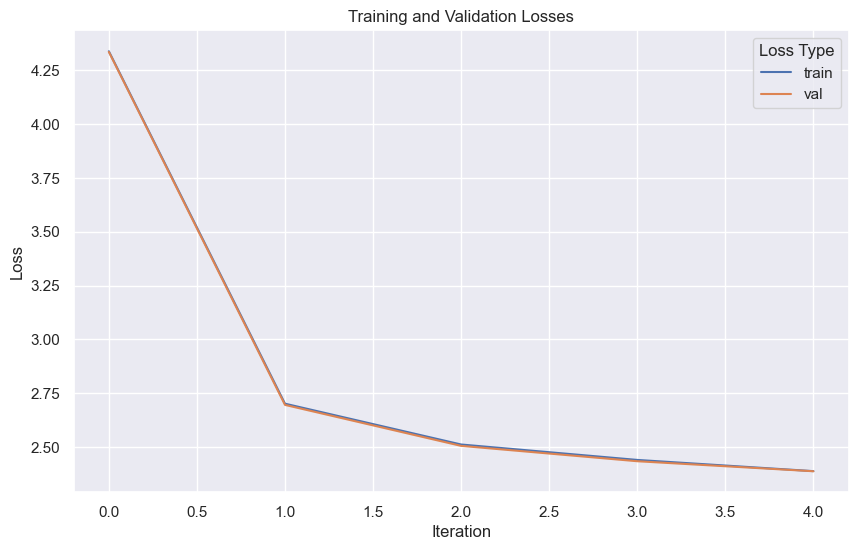

In [17]:
df = pd.DataFrame({
    'iter': range(len(all_losses[DataSplit.TRAIN.name])),
    'train': all_losses[DataSplit.TRAIN.name],
    'val': all_losses[DataSplit.VALIDATION.name]
})

# Melt the DataFrame to create a "long-form" DataFrame
df_melted = pd.melt(df, id_vars=['iter'], value_vars=['train', 'val'],
                    var_name='loss_type', value_name='loss')

# Create the plot
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='iter', y='loss', hue='loss_type')

plt.title('Training and Validation Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(title='Loss Type')

plt.show()

In [18]:
torch.save(model, 'weights/tinyGPT.pb')